## Transcription factor sub-subnetwork

From our simulation experiments, it seems like we have two big problems: a) discretization will give misleading directions of the changes in expression, esppecially when we have multiple edges pointing to the same node and b) that the prediction error will increase as the distance to the heat shock starters increases. Also, it seems that only about 15 transcription factors are included in the heat-shock subnetwork. Because of this, I want to try to model the heat shock subnetwork as accurately as possible to have some hope in determining the sign of the change.

In particular, I propose to start by modeling only the (15 nodes) transcription factor subnetwork, but to use a relatively rich set of parameters to be able to model it semi-accurately. That model can then be expanded to the full heat shock subnetwork.

### 1. Get the transcription factor sub-sub network

In [34]:
import numpy as np
import pandas as pd
import networkx as nx

from yeastnet import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [2]:
# Read full network data.
#yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
#yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")

# Read heat-shock network data.
yeastract_data_activation = get_yeastract_data("heat_shock_act.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("heat_shock_inh.csv","tftoorf.csv")

# Transform into matrices (as np.array).
Aa = squarify(yeastract_data_activation)
Ai = squarify(yeastract_data_inhibition)

# Read timecourse data.
cols = list(Aa.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)

# Reorder matrices to have same order than timecourse data.
Aa = reorder(list(gasch_data.index), Aa)
Ai = reorder(list(gasch_data.index), Ai)

# Turn into networkx objects.
network_act = nx.DiGraph(data=np.array(Aa))
network_inh = nx.DiGraph(data=np.array(Ai))
names = list(Aa)

network_act = nx.relabel_nodes(network_act, {i:name for i, name in enumerate(names)})
network_inh = nx.relabel_nodes(network_inh, {i:name for i, name in enumerate(names)})

In [3]:
network_act.degree('HSF1')

67

In [4]:
# Heat shock network subgraph.
def remove_singletons(network_act, network_inh):
    '''
    Removes all unconnected nodes from the network.
    '''
    nodelist = []
    for node in network_act.nodes():
        if network_act.degree(node) != 0 or network_inh.degree(node) != 0:
            nodelist.append(node)
    return network_act.subgraph(nodelist), network_inh.subgraph(nodelist)

def tf_subgraphs(network_act, network_inh):
    '''
    Get subgraph with transcription factors only.
    '''
    nodelist = []
    for node in network_act.nodes():
        if network_act.out_degree(node) != 0:
            nodelist.append(node)
    return network_act.subgraph(nodelist), network_inh.subgraph(nodelist)

In [5]:
hs_act, hs_inh = remove_singletons(network_act, network_inh)
hs_tf_act, hs_tf_inh = tf_subgraphs(network_act, network_inh)

In [6]:
len(network_act.nodes())

6855

In [7]:
len(hs_act.nodes())

734

In [8]:
len(hs_tf_act.nodes())

15

In [9]:
Aa_hstf = nx.adjacency_matrix(hs_tf_act)
print(Aa_hstf)

  (6, 6)	1


In [10]:
print(nx.adjacency_matrix(hs_tf_inh))

  (4, 4)	1


There's only two interactions, making this network completely useless.

## An alternative approach: get all downstream nodes from HSS that are TFs

In [11]:
# Read full network data.
yeastract_data_activation = get_yeastract_data("matrix_activator.csv","tftoorf.csv")
yeastract_data_inhibition = get_yeastract_data("matrix_inhibitor.csv","tftoorf.csv")

# Transform into matrices (as np.array).
Aa = squarify(yeastract_data_activation)
Ai = squarify(yeastract_data_inhibition)

# Read timecourse data.
cols = list(Aa.columns)
gasch_data = get_gasch_data("complete_dataset_gasch.txt","orfname_time_course_fixed.csv",cols)

# Reorder matrices to have same order than timecourse data.
Aa = reorder(list(gasch_data.index), Aa)
Ai = reorder(list(gasch_data.index), Ai)

names = list(Aa)

Aa, Ai = np.array(Aa), np.array(Ai)

# Remove diagonal elements.
np.fill_diagonal(Aa, 0) 
np.fill_diagonal(Ai, 0)


# Turn into networkx objects.
network_act = nx.DiGraph(data=np.array(Aa))
network_inh = nx.DiGraph(data=np.array(Ai))


network_act = nx.relabel_nodes(network_act, {i:name for i, name in enumerate(names)})
network_inh = nx.relabel_nodes(network_inh, {i:name for i, name in enumerate(names)})

In [12]:
def hss_successors(mixed_network, starters, only_tf=True):
    nodelist = []
    for node in mixed_network.nodes():
        # Check if there exists a path from any of the HSS to current node.
        if np.any([nx.has_path(mixed_network, st, node) for st in starters]):
            if not only_tf:
                nodelist.append(node)
            elif mixed_network.out_degree(node) != 0:
                nodelist.append(node)
    return nodelist

In [13]:
W = Aa - Ai
mixed_network = nx.DiGraph(data=np.array(W))
#names = list(W)
mixed_network = nx.relabel_nodes(mixed_network, {i:name for i, name in enumerate(names)})

In [14]:
len(mixed_network.nodes())

6855

In [15]:
heat_shock_starters = ["HSF1", "MSN2", "MSN4", "RLM1", "SWI4"]
subnet_nodelist = hss_successors(mixed_network, heat_shock_starters, only_tf=True)

In [16]:
def combine_networks(act, inh):
    Aa = nx.adjacency_matrix(act).toarray()
    Ai = nx.adjacency_matrix(inh).toarray()
    W = Aa - Ai
    
    mixed_network = nx.DiGraph(data=np.array(W))
    names = act.nodes()
    mixed_network = nx.relabel_nodes(mixed_network, {i:name for i, name in enumerate(names)})
    return mixed_network
    

In [17]:
def shortest_path_length(network, s, node):
    try:
        return nx.shortest_path_length(network, s, node)
    except:
        return np.inf

def shortest_path_to_hss(network, node, starters):
    #print(node)
    path_lengths = [shortest_path_length(network, s, node) for s in starters]
    return min(path_lengths)

In [18]:
?nx.shortest_path

In [19]:
sn_act, sn_inh = network_act.subgraph(subnet_nodelist), network_inh.subgraph(subnet_nodelist)
sn = combine_networks(sn_act, sn_inh)

In [20]:
for node in sn_act.nodes():
    print(shortest_path_to_hss(sn, node, heat_shock_starters),
          node, sn_act.in_degree(node), sn_inh.in_degree(node), sn_act.in_degree(node) + sn_inh.in_degree(node))

3 PDR3 3 1 4
4 RTG3 2 1 3
2 REB1 2 0 2
1 TEC1 1 3 4
2 SMP1 2 2 4
3 ERT1 1 0 1
3 HCM1 1 2 3
5 RDS1 1 0 1
1 RPN4 5 2 7
5 UGA3 2 1 3
1 NRG1 5 4 9
3 SWI5 3 2 5
1 UME6 0 2 2
3 UPC2 1 1 2
1 ADR1 2 2 4
3 MET32 2 1 3
1 YAP6 4 0 4
3 SUM1 1 0 1
1 YHP1 2 3 5
2 GCN4 1 0 1
3 MIG3 0 2 2
1 ACA1 1 1 2
2 FLO8 2 0 2
0 SWI4 0 2 2
3 RPH1 1 0 1
1 GAT1 6 3 9
3 HAC1 2 3 5
1 PHO4 1 1 2
1 PDR1 1 2 3
6 AFT1 0 1 1
0 HSF1 0 0 0
2 TOS8 6 1 7
1 CUP2 1 3 4
1 MIG2 2 1 3
1 RME1 1 1 2
2 MGA1 3 4 7
3 YAP3 1 0 1
3 RIM101 0 1 1
2 STE12 1 0 1
2 NDT80 2 0 2
5 STB5 1 0 1
3 SKN7 0 1 1
3 CST6 0 1 1
1 XBP1 7 3 10
1 MET28 6 6 12
2 YAP5 2 2 4
3 MGA2 1 0 1
2 CBF1 1 0 1
1 IME1 3 3 6
1 HMS2 4 5 9
2 IXR1 1 6 7
3 RGT1 1 0 1
1 PHD1 6 5 11
0 MSN4 3 2 5
1 HAP4 4 5 9
3 ASH1 1 1 2
2 DAL80 1 2 3
2 GAT3 1 0 1
3 PPR1 1 0 1
3 ECM22 1 0 1
3 HAP1 2 3 5
2 SFP1 1 0 1
3 LEU3 2 1 3
4 YAP1 2 1 3
2 SOK2 1 3 4
0 MSN2 1 2 3
1 ARG80 1 1 2
1 MOT3 1 3 4
2 MSS11 2 0 2
4 HOT1 0 1 1
3 RGM1 2 0 2
3 CAT8 0 2 2
2 CRZ1 0 2 2
3 MET4 3 1 4
2 CIN5 5 3 8
2 HMS1 6 6 1

In [21]:
for node in heat_shock_starters:
    print(shortest_path_to_hss(sn, node, heat_shock_starters),
          node, sn_act.out_degree(node), sn_inh.out_degree(node), sn_act.out_degree(node) + sn_inh.out_degree(node))

0 HSF1 2 1 3
0 MSN2 16 21 37
0 MSN4 1 2 3
0 RLM1 0 0 0
0 SWI4 5 4 9


In [22]:
for node in heat_shock_starters:
    print(shortest_path_to_hss(sn, node, heat_shock_starters),
          node, sn_act.in_degree(node), sn_inh.in_degree(node), sn_act.in_degree(node) + sn_inh.in_degree(node))

0 HSF1 0 0 0
0 MSN2 1 2 3
0 MSN4 3 2 5
0 RLM1 0 0 0
0 SWI4 0 2 2


In [23]:
list(sn_inh.predecessors('MSN2'))

['STE12', 'TYE7']

In [24]:
list(sn_act.predecessors('MSN4'))

['SKN7', 'SOK2', 'MSN2']

In [25]:
path_lengths = np.array([shortest_path_to_hss(sn, node, heat_shock_starters) for node in sn.nodes()])
nodes = np.array(sn.nodes())

nodes[path_lengths <= 2]

array(['REB1', 'TEC1', 'SMP1', 'RPN4', 'NRG1', 'UME6', 'ADR1', 'YAP6',
       'YHP1', 'GCN4', 'ACA1', 'FLO8', 'SWI4', 'GAT1', 'PHO4', 'PDR1',
       'HSF1', 'TOS8', 'CUP2', 'MIG2', 'RME1', 'MGA1', 'STE12', 'NDT80',
       'XBP1', 'MET28', 'YAP5', 'CBF1', 'IME1', 'HMS2', 'IXR1', 'PHD1',
       'MSN4', 'HAP4', 'DAL80', 'GAT3', 'SFP1', 'SOK2', 'MSN2', 'ARG80',
       'MOT3', 'MSS11', 'CRZ1', 'CIN5', 'HMS1', 'SFL1', 'WTM1', 'TYE7',
       'PIP2', 'RLM1', 'USV1', 'ROX1'],
      dtype='<U6')

In [26]:
for node in subnet_nodelist:
    print(node, sn_act.out_degree(node), sn_inh.out_degree(node), sn_act.out_degree(node) + sn_inh.out_degree(node))

PDR3 3 0 3
RTG3 0 0 0
REB1 0 0 0
TEC1 12 6 18
SMP1 0 0 0
ERT1 0 1 1
HCM1 0 0 0
RDS1 0 0 0
RPN4 3 2 5
UGA3 0 0 0
NRG1 1 1 2
SWI5 2 1 3
UME6 3 1 4
UPC2 0 0 0
ADR1 3 0 3
MET32 1 1 2
YAP6 1 1 2
SUM1 1 0 1
YHP1 0 0 0
GCN4 8 6 14
MIG3 0 0 0
ACA1 0 0 0
FLO8 4 2 6
SWI4 5 4 9
RPH1 0 0 0
GAT1 0 0 0
HAC1 0 0 0
PHO4 2 1 3
PDR1 6 3 9
AFT1 0 1 1
HSF1 2 1 3
TOS8 0 0 0
CUP2 0 0 0
MIG2 0 0 0
RME1 0 0 0
MGA1 1 0 1
YAP3 0 0 0
RIM101 1 3 4
STE12 33 16 49
NDT80 0 0 0
STB5 0 1 1
SKN7 8 1 9
CST6 0 0 0
XBP1 1 5 6
MET28 1 0 1
YAP5 0 0 0
MGA2 0 0 0
CBF1 4 5 9
IME1 0 0 0
HMS2 0 0 0
IXR1 0 1 1
RGT1 0 1 1
PHD1 0 1 1
MSN4 1 2 3
HAP4 1 0 1
ASH1 1 1 2
DAL80 0 1 1
GAT3 0 0 0
PPR1 0 0 0
ECM22 0 0 0
HAP1 2 1 3
SFP1 4 1 5
LEU3 1 1 2
YAP1 13 6 19
SOK2 7 20 27
MSN2 16 21 37
ARG80 0 0 0
MOT3 0 0 0
MSS11 0 0 0
HOT1 0 0 0
RGM1 0 0 0
CAT8 0 0 0
CRZ1 5 3 8
MET4 5 7 12
CIN5 3 1 4
HMS1 0 0 0
SFL1 0 0 0
YRM1 1 2 3
WTM1 0 0 0
TYE7 0 1 1
PIP2 0 1 1
RLM1 0 0 0
CUP9 0 0 0
AFT2 0 2 2
USV1 0 0 0
ROX1 2 2 4


In [27]:
for k, v in mixed_network.out_degree(subnet_nodelist):
    print(k, v)

PDR3 34
RTG3 18
REB1 42
TEC1 282
SMP1 2
ERT1 5
HCM1 14
RDS1 2
RPN4 48
UGA3 4
NRG1 36
SWI5 74
UME6 62
UPC2 2
ADR1 87
MET32 38
YAP6 14
SUM1 30
YHP1 39
GCN4 77
MIG3 4
ACA1 1
FLO8 56
SWI4 111
RPH1 8
GAT1 8
HAC1 6
PHO4 54
PDR1 85
AFT1 62
HSF1 87
TOS8 9
CUP2 1
MIG2 3
RME1 7
MGA1 31
YAP3 2
RIM101 37
STE12 875
NDT80 3
STB5 40
SKN7 111
CST6 29
XBP1 87
MET28 13
YAP5 36
MGA2 7
CBF1 136
IME1 1
HMS2 1
IXR1 32
RGT1 10
PHD1 33
MSN4 88
HAP4 34
ASH1 62
DAL80 5
GAT3 6
PPR1 3
ECM22 7
HAP1 34
SFP1 90
LEU3 24
YAP1 201
SOK2 310
MSN2 579
ARG80 8
MOT3 15
MSS11 10
HOT1 13
RGM1 5
CAT8 10
CRZ1 48
MET4 25
CIN5 199
HMS1 7
SFL1 2
YRM1 120
WTM1 1
TYE7 26
PIP2 40
RLM1 34
CUP9 16
AFT2 29
USV1 1
ROX1 39


#### Read HSS parameters from previous fit

In [28]:
prot_params = pd.read_csv('hss_params_prot.csv')
prot_params

,tf,u0,kf0,k_prot
0,HSF1,0.043641,0.121946,0.052346
1,MSN2,0.039244,0.343173,0.028179
2,MSN4,0.172862,0.543289,0.023210
3,RLM1,0.050708,0.099861,0.088440
4,SWI4,0.004864,0.014643,0.213831


In [29]:
rna_params = pd.read_csv('hss_params_rna.csv')
rna_params

,tf,u0,kf0
0,HSF1,0.149537,0.365273
1,MSN2,0.082036,0.621241
2,MSN4,0.268617,0.309133
3,RLM1,2.480245,4.203806
4,SWI4,0.075754,0.482932


In [30]:
# Model 1: mRNA only, separate inhibition and activation.
def f(y, t0, u, ka, ki, kf, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    A = ka * Aa - ki * Ai
    
    #return (A - kf * np.identity(len(A))) @ y + u
    return A @ y - kf * y + u

# Model 2: mRNA only, separate inhibition and activation, max activation (tanh).
def f2(y, t0, u, ka, ki, kf, k_max, k_width, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    A = ka * Aa - ki * Ai
    
    #return (A - kf * np.identity(len(A))) @ y + u
    return k_max * np.tanh((A @ y) / k_width) - kf * y + u

# Model 3: mRNA and protein, separate inhibition and activation, linear activation.
def f3(y, t0, u, ka, ki, kf, k_prot, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = ka * Aa - ki * Ai
    
    dm = (A @ p) - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

# Model 4: mRNA and protein, separate inhibition and activation, max activation (tanh).
def f4(y, t0, u, ka, ki, kf, k_max, k_width, k_prot, Aa, Ai):
    '''
    u: vector of initial conditions.
    ka: activator strength.
    ki: inhibitor strength.
    kf: vector of feedbacks for each gene.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = ka * Aa - ki * Ai
    
    dm = k_max * np.tanh(A @ p / k_width) - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

In [31]:
# Model 3: mRNA and protein, separate inhibition and activation, linear activation.
def f3(y, t0, u, k_tf, kf, k_prot, Aa, Ai):
    '''
    u: N-vector of initial activation strength.
    k_tf: N-vector of TF strengths.
    kf: N-vector of feedbacks for each gene.
    k_prot: Protein constant.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = Aa - Ai
    #print(A.shape)
    A = (k_tf * A.transpose()).transpose()
    
    dm = A @ p - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

def error_prot_model(params, y_data, N, hss_indices, Aa, Ai, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.
    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    k_prot = params[-1]
    
    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, k_tf, kf, k_prot, Aa, Ai))
    m = y[:,:N]
    
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

def get_predictions_f3(params, hss_indices, Aa, Ai, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=5):
    N = Aa.shape[0]
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    #print('u0', len(u0))
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    #print('kf', len(kf), kf)
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    #print('k_tf', len(k_tf))
    k_prot = params[-1]
    #print(k_prot)

    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=times,
               args=(u, k_tf, kf, k_prot, Aa, Ai),)
    return y[:,:N]

We need a smaller system to test this in at first... Let's try just taking the first neighbors of the TFs.

In [32]:
nodes1 = list(nodes[path_lengths <= 1])
sn1_act, sn1_inh = sn_act.subgraph(nodes1), sn_inh.subgraph(nodes1)

A1a, A1i = nx.adjacency_matrix(sn1_act), nx.adjacency_matrix(sn1_inh)
#print(A1a)
#print()
#print(A1i)

A1a, A1i = A1a.toarray().transpose(), A1i.toarray().transpose()
#A1a, A1i = A1a.transpose(), A1i.transpose()

N = len(nodes1)
hss_indices = [nodes1.index(tf) for tf in heat_shock_starters]

init_params = np.array(list(prot_params.iloc[:,1]) + list(prot_params.iloc[:, 2])
                       + [0.7] * (N - 5) + [0.1] * N + [0.05])
bounds = ([(0.01, 1)] * 5 + [(0.1, 10)] * N + [(0, 1)] * N + [(0.02, 1)])

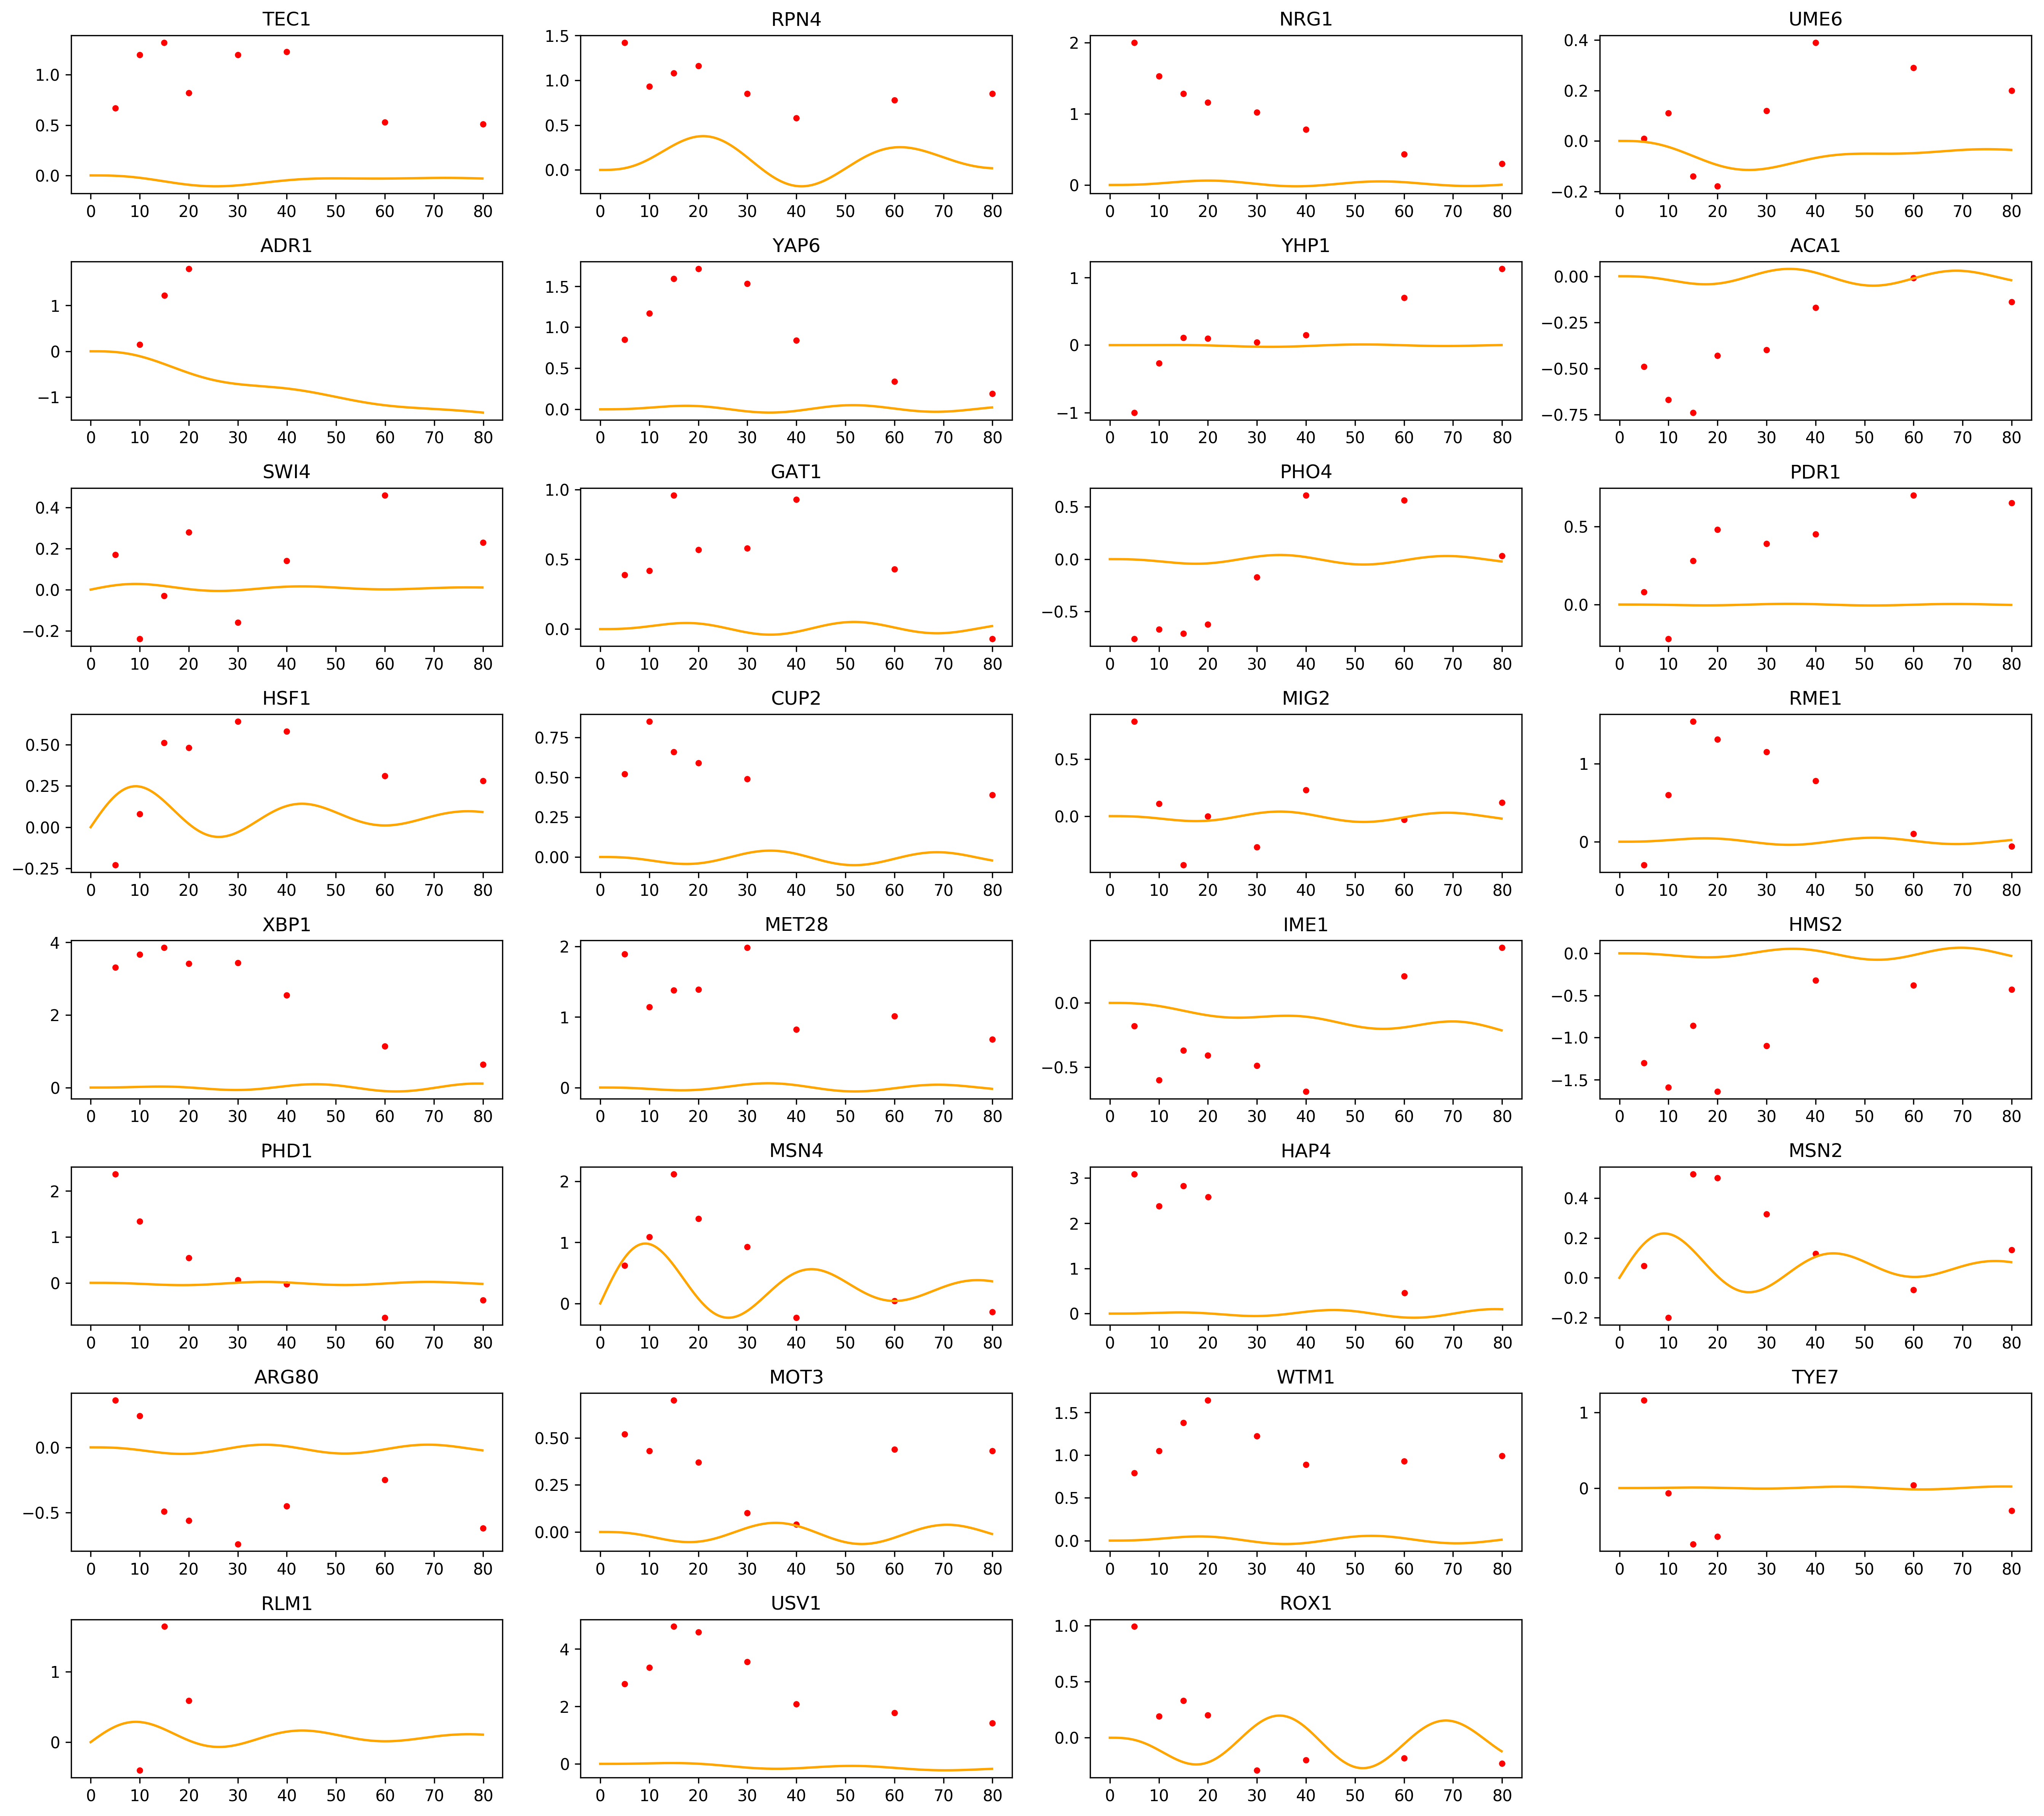

In [38]:
ts = np.arange(0, 80, 0.1)
times = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
y_pred = get_predictions_f3(init_params, hss_indices, A1a, A1i, times=ts, n_hss=5)
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]

plt.figure(figsize=(18, 16), dpi=300)
for i, node in enumerate(nodes1):
    plt.subplot(8, 4, i + 1)
    plt.plot(times[1:], y_data.iloc[i,:], '.', color="red")
    plt.plot(ts, y_pred[:, i], '-', color="orange")
    plt.title(node)
    #plt.plot(times, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '.-', color = 'red', alpha=0.3)
    #plt.xlim(0, 80)
    #plt.ylim(-2, 3)
plt.tight_layout()
plt.show()

In [39]:
len(init_params) - len(bounds)

0

In [40]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]
y_data = np.array(y_data).transpose()

In [41]:
from scipy.optimize import minimize

fit_params = minimize(error_prot_model, x0=init_params,
                  args=(y_data, N, hss_indices, A1a, A1i),
                     bounds=bounds)

In [42]:
fit_params

      fun: 0.55889599241612387
 hess_inv: <68x68 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.52355614e-02,  -4.80223306e-02,   2.28014829e-02,
         7.58795249e-03,   6.40690612e-02,   0.00000000e+00,
         1.53075552e-02,   1.70430448e-02,   0.00000000e+00,
        -9.67337321e-05,  -7.50708384e-03,  -1.19034782e-03,
        -1.49023016e-03,  -3.83504339e-04,   2.34706699e-03,
        -7.97417687e-04,   0.00000000e+00,   3.15872883e-03,
         0.00000000e+00,   0.00000000e+00,  -2.96366265e-03,
         3.50075191e-02,   0.00000000e+00,   1.32231781e-02,
        -5.43324274e-03,   1.96731520e-05,  -1.95231720e-02,
         5.67494940e-03,   4.61831795e-02,   7.39780459e-03,
         0.00000000e+00,   8.43223269e-03,  -8.78168649e-03,
        -6.17598195e-03,   1.04234776e-01,   0.00000000e+00,
         5.07459963e-02,   1.39419365e-02,  -9.81889015e-03,
         1.29970479e-03,   1.00599185e-01,   1.40825906e-02,
         3.76887410e-04,   1.34508404e-02,   0

In [43]:
# Try fitting again from found parameters.
fit_params = minimize(error_prot_model, x0=fit_params.x,
                  args=(y_data, N, hss_indices, A1a, A1i),
                     bounds=bounds)

In [44]:
len(fit_params.x)

68

In [45]:
A1a.shape

(31, 31)

In [66]:
#ts = np.arange(0, 120, 1)
ts = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
hss_indices = [nodes1.index(tf) for tf in heat_shock_starters]

y_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=ts, n_hss=5)

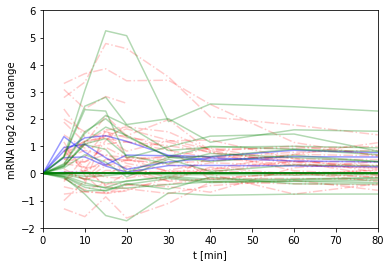

In [67]:
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]
#y_data = [0] * len(y_data)
plt.plot(times[1:], np.transpose(y_data), '-.', color="red", alpha=0.2)
plt.plot(ts, y_pred[:, hss_indices], '-', color="blue", alpha=0.4)
plt.plot(ts, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '-', color = 'green', alpha=0.3)
plt.xlabel('t [min]')
plt.ylabel('mRNA log2 fold change')
plt.xlim(0, 80)
plt.ylim(-2, 6)
plt.show()

In [48]:
fit_params

      fun: 0.53612285899317014
 hess_inv: <68x68 LbfgsInvHessProduct with dtype=float64>
      jac: array([  5.59448932e-02,  -1.02221465e-01,  -2.97249891e-02,
        -1.30228939e-02,  -2.59037458e-02,   0.00000000e+00,
        -1.47516444e-02,   1.81446969e-02,  -1.36368694e-04,
         0.00000000e+00,  -8.37283576e-03,  -2.55462318e-05,
        -2.88957747e-03,  -3.89988042e-04,  -4.74245088e-03,
         3.95966371e-02,   0.00000000e+00,  -4.27656244e-02,
         0.00000000e+00,   0.00000000e+00,   7.71551711e-03,
         2.47391108e-02,   0.00000000e+00,   3.53829188e-03,
        -3.58049479e-02,  -8.12161449e-04,   1.80532700e-02,
         3.28450600e-02,   5.06182984e-02,   4.00482203e-02,
         0.00000000e+00,   2.79251511e-02,   4.01751521e-02,
         1.85325866e-02,   4.18957424e-02,   0.00000000e+00,
         1.78577453e-01,   2.34388731e-02,  -1.00066733e-02,
        -4.56393812e-03,   1.34840916e-01,   7.15294490e-04,
        -6.96609437e-04,   1.16612275e-02,   0

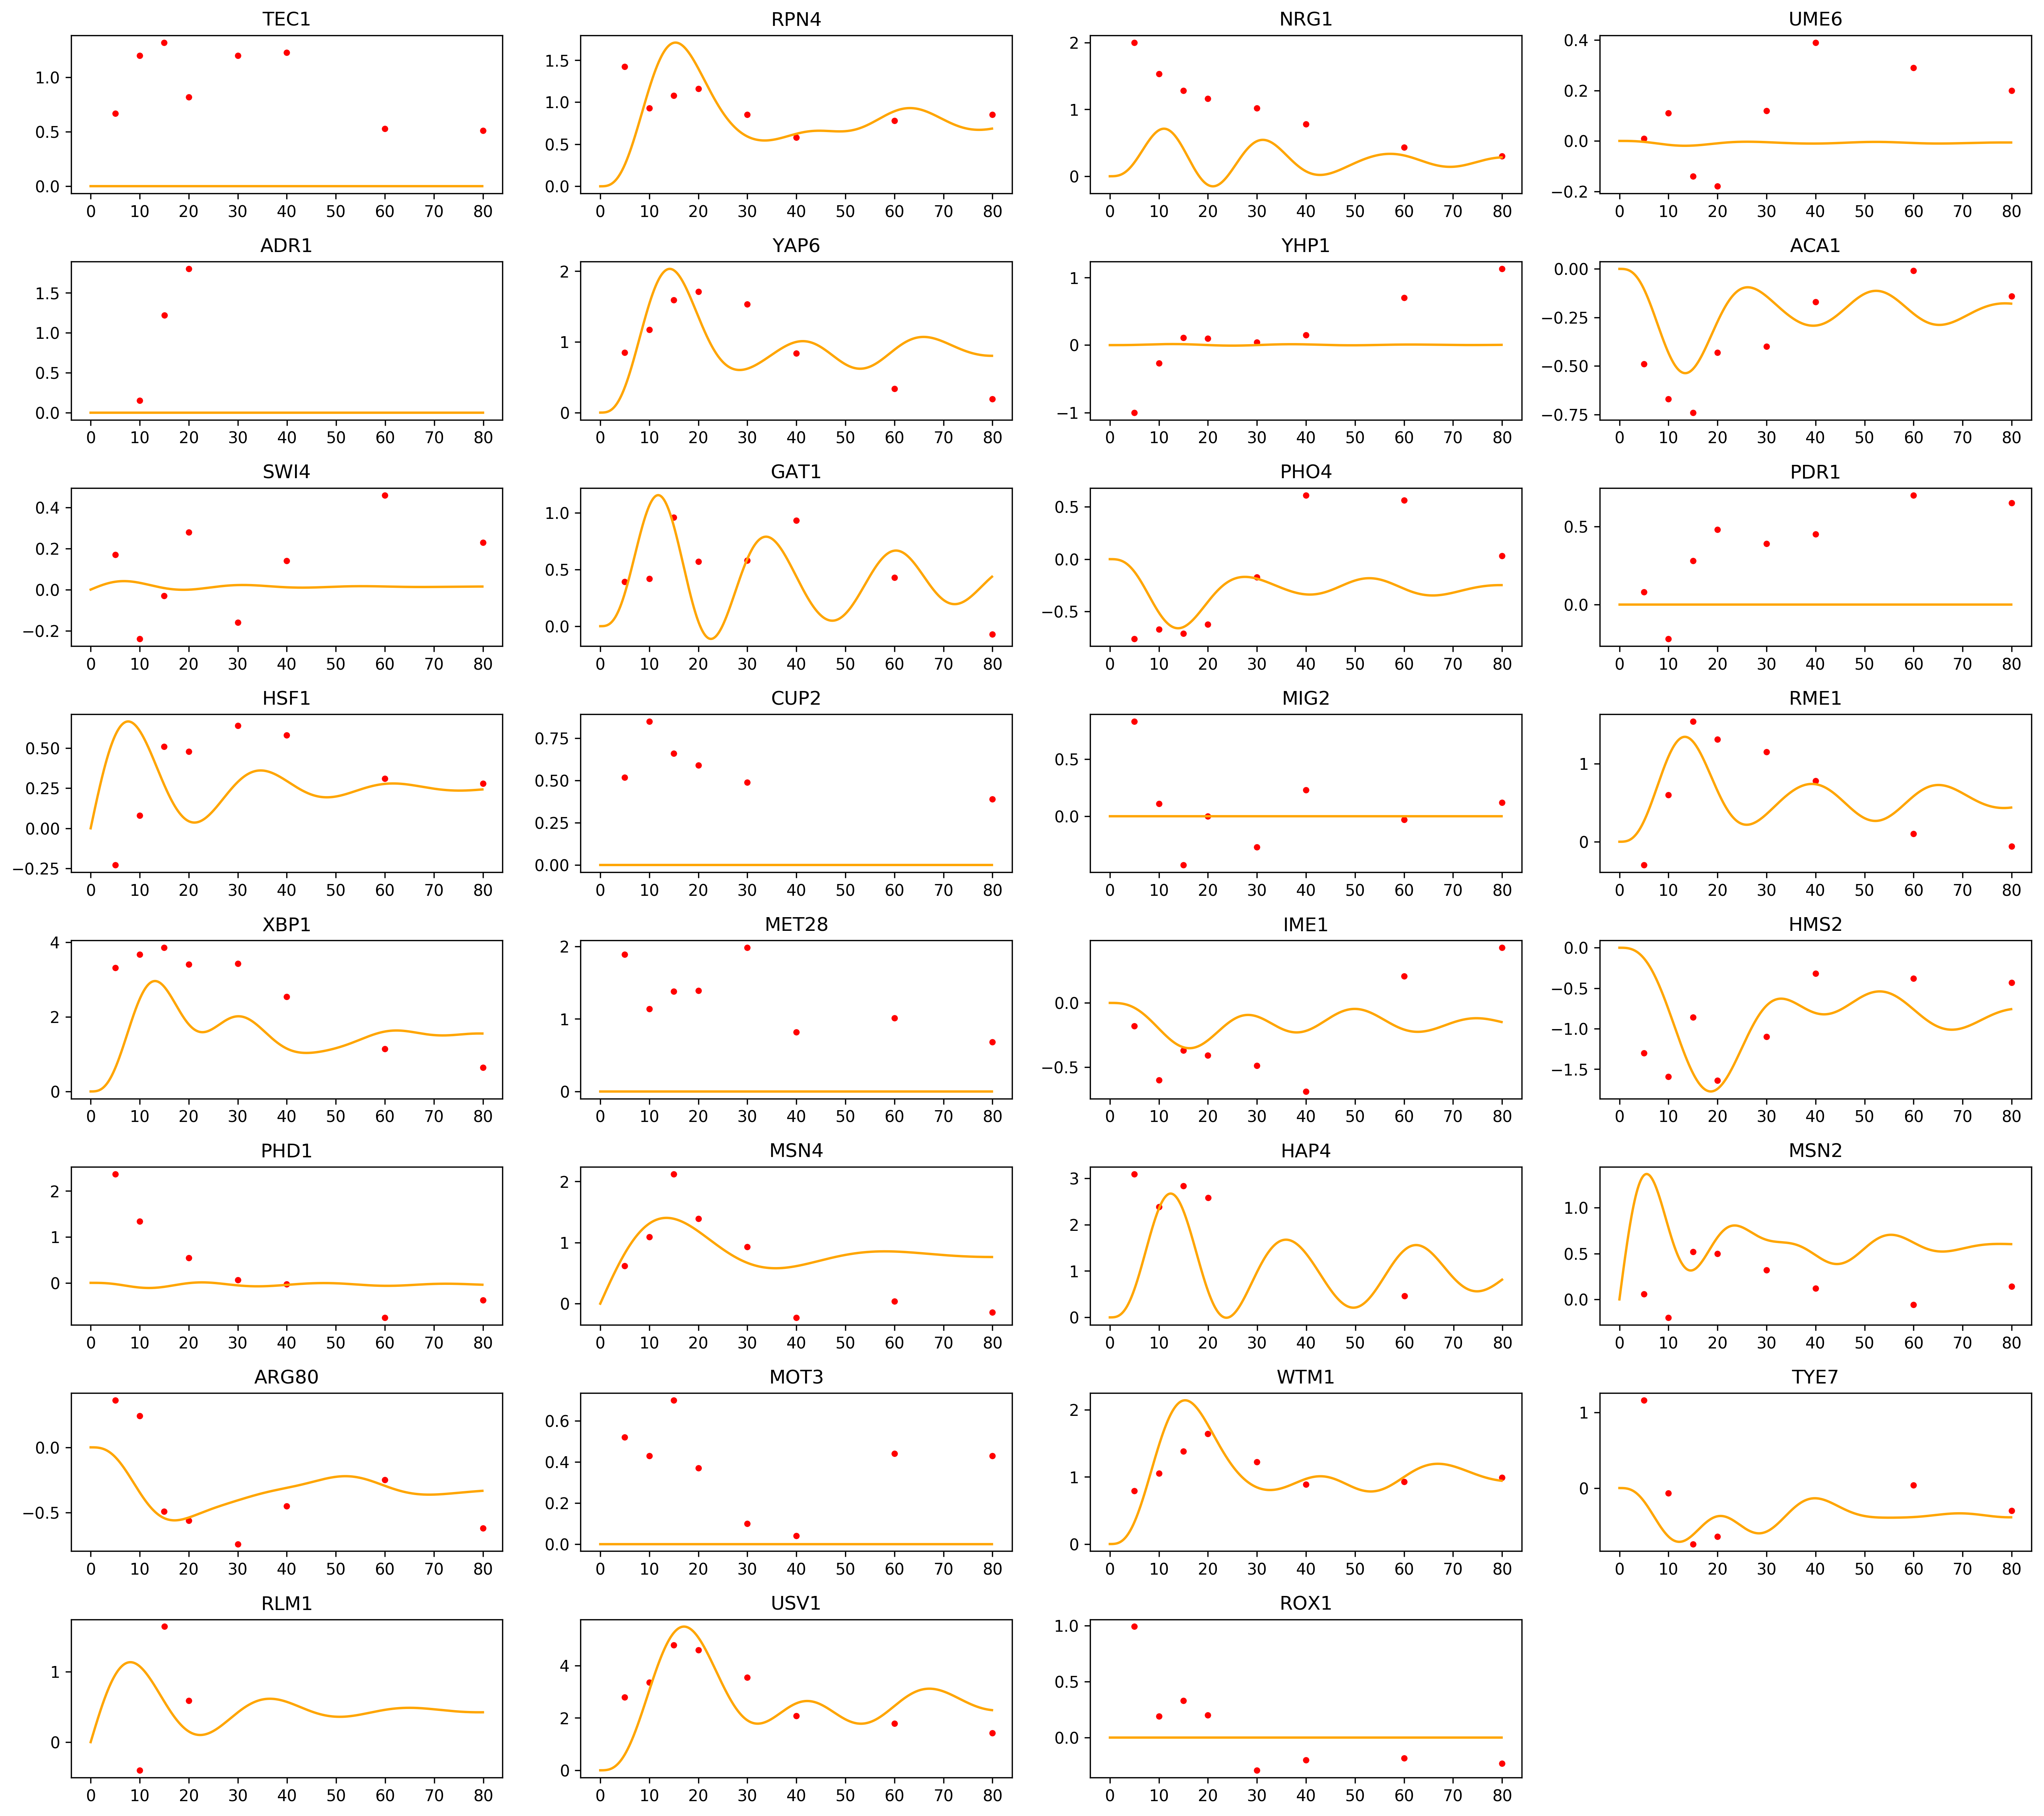

In [49]:
ts = np.arange(0, 80, 0.1)
y_pred = get_predictions_f3(fit_params.x, hss_indices, A1a, A1i, times=ts, n_hss=5)
y_data = gasch_data.iloc[:, 2:10].loc[nodes1]

plt.figure(figsize=(18, 16), dpi=300)
for i, node in enumerate(nodes1):
    plt.subplot(8, 4, i + 1)
    plt.plot(times[1:], y_data.iloc[i,:], '.', color="red")
    plt.plot(ts, y_pred[:, i], '-', color="orange")
    plt.title(node)
    #plt.plot(times, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '.-', color = 'red', alpha=0.3)
    #plt.xlim(0, 80)
    #plt.ylim(-2, 3)
plt.tight_layout()
plt.show()

**Conclusion 1:** The linear model sucks.

**Conclusion 2:** But while we're doing this, we might as well try the whole TF network to see if this improves since it's almost the same code.

In [50]:
heat_shock_starters

['HSF1', 'MSN2', 'MSN4', 'RLM1', 'SWI4']

In [51]:
N = len(subnet_nodelist)
hss_indices = [subnet_nodelist.index(tf) for tf in heat_shock_starters]

init_params = np.array(list(prot_params.iloc[:,1]) + list(prot_params.iloc[:, 2])
                       + [0.7] * (N - 5) + [0.1] * N + [0.05])
bounds = ([(0.01, 1)] * 5 + [(0, 10)] * N + [(0, 1)] * N + [(0, 1)])

In [52]:
y_data = gasch_data.iloc[:, 2:10].loc[subnet_nodelist]
y_data = np.array(y_data).transpose()

Aa, Ai = nx.adjacency_matrix(sn_act), nx.adjacency_matrix(sn_inh)

Aa, Ai = Aa.toarray().transpose(), Ai.toarray().transpose()

In [53]:
from scipy.optimize import minimize

fit_params_full = minimize(error_prot_model, x0=init_params,
                  args=(y_data, N, hss_indices, Aa, Ai), bounds=bounds)

In [54]:
fit_params_full

      fun: 0.6029883379815969
 hess_inv: <178x178 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.18001506e-02,  -3.30767636e-03,  -4.65530392e-02,
         8.94074814e-03,  -1.36051170e-03,  -6.27942143e-05,
        -4.03010958e-06,   1.61759495e-05,   3.20699023e-04,
         1.61538560e-03,   5.26245714e-06,  -1.58761893e-05,
         1.33226763e-07,  -4.27402558e-04,   1.11022302e-07,
        -1.08686393e-03,   2.39808173e-06,   1.69420034e-05,
         2.33812969e-05,   1.38229428e-03,   1.02362563e-05,
         2.76593193e-03,   1.25011113e-05,  -4.29989377e-05,
         8.22342194e-05,   3.08642001e-06,   3.80184773e-04,
         2.44249065e-05,   2.54785082e-04,   1.29007915e-05,
         1.51851864e-03,  -2.70339306e-05,  -1.76703097e-04,
        -1.02395870e-04,   0.00000000e+00,   3.28849170e-03,
        -2.78155277e-04,   0.00000000e+00,   4.24105195e-06,
         1.44503298e-03,   2.23154828e-06,   1.29007915e-05,
         1.16573418e-06,   3.27182725e-05,  -

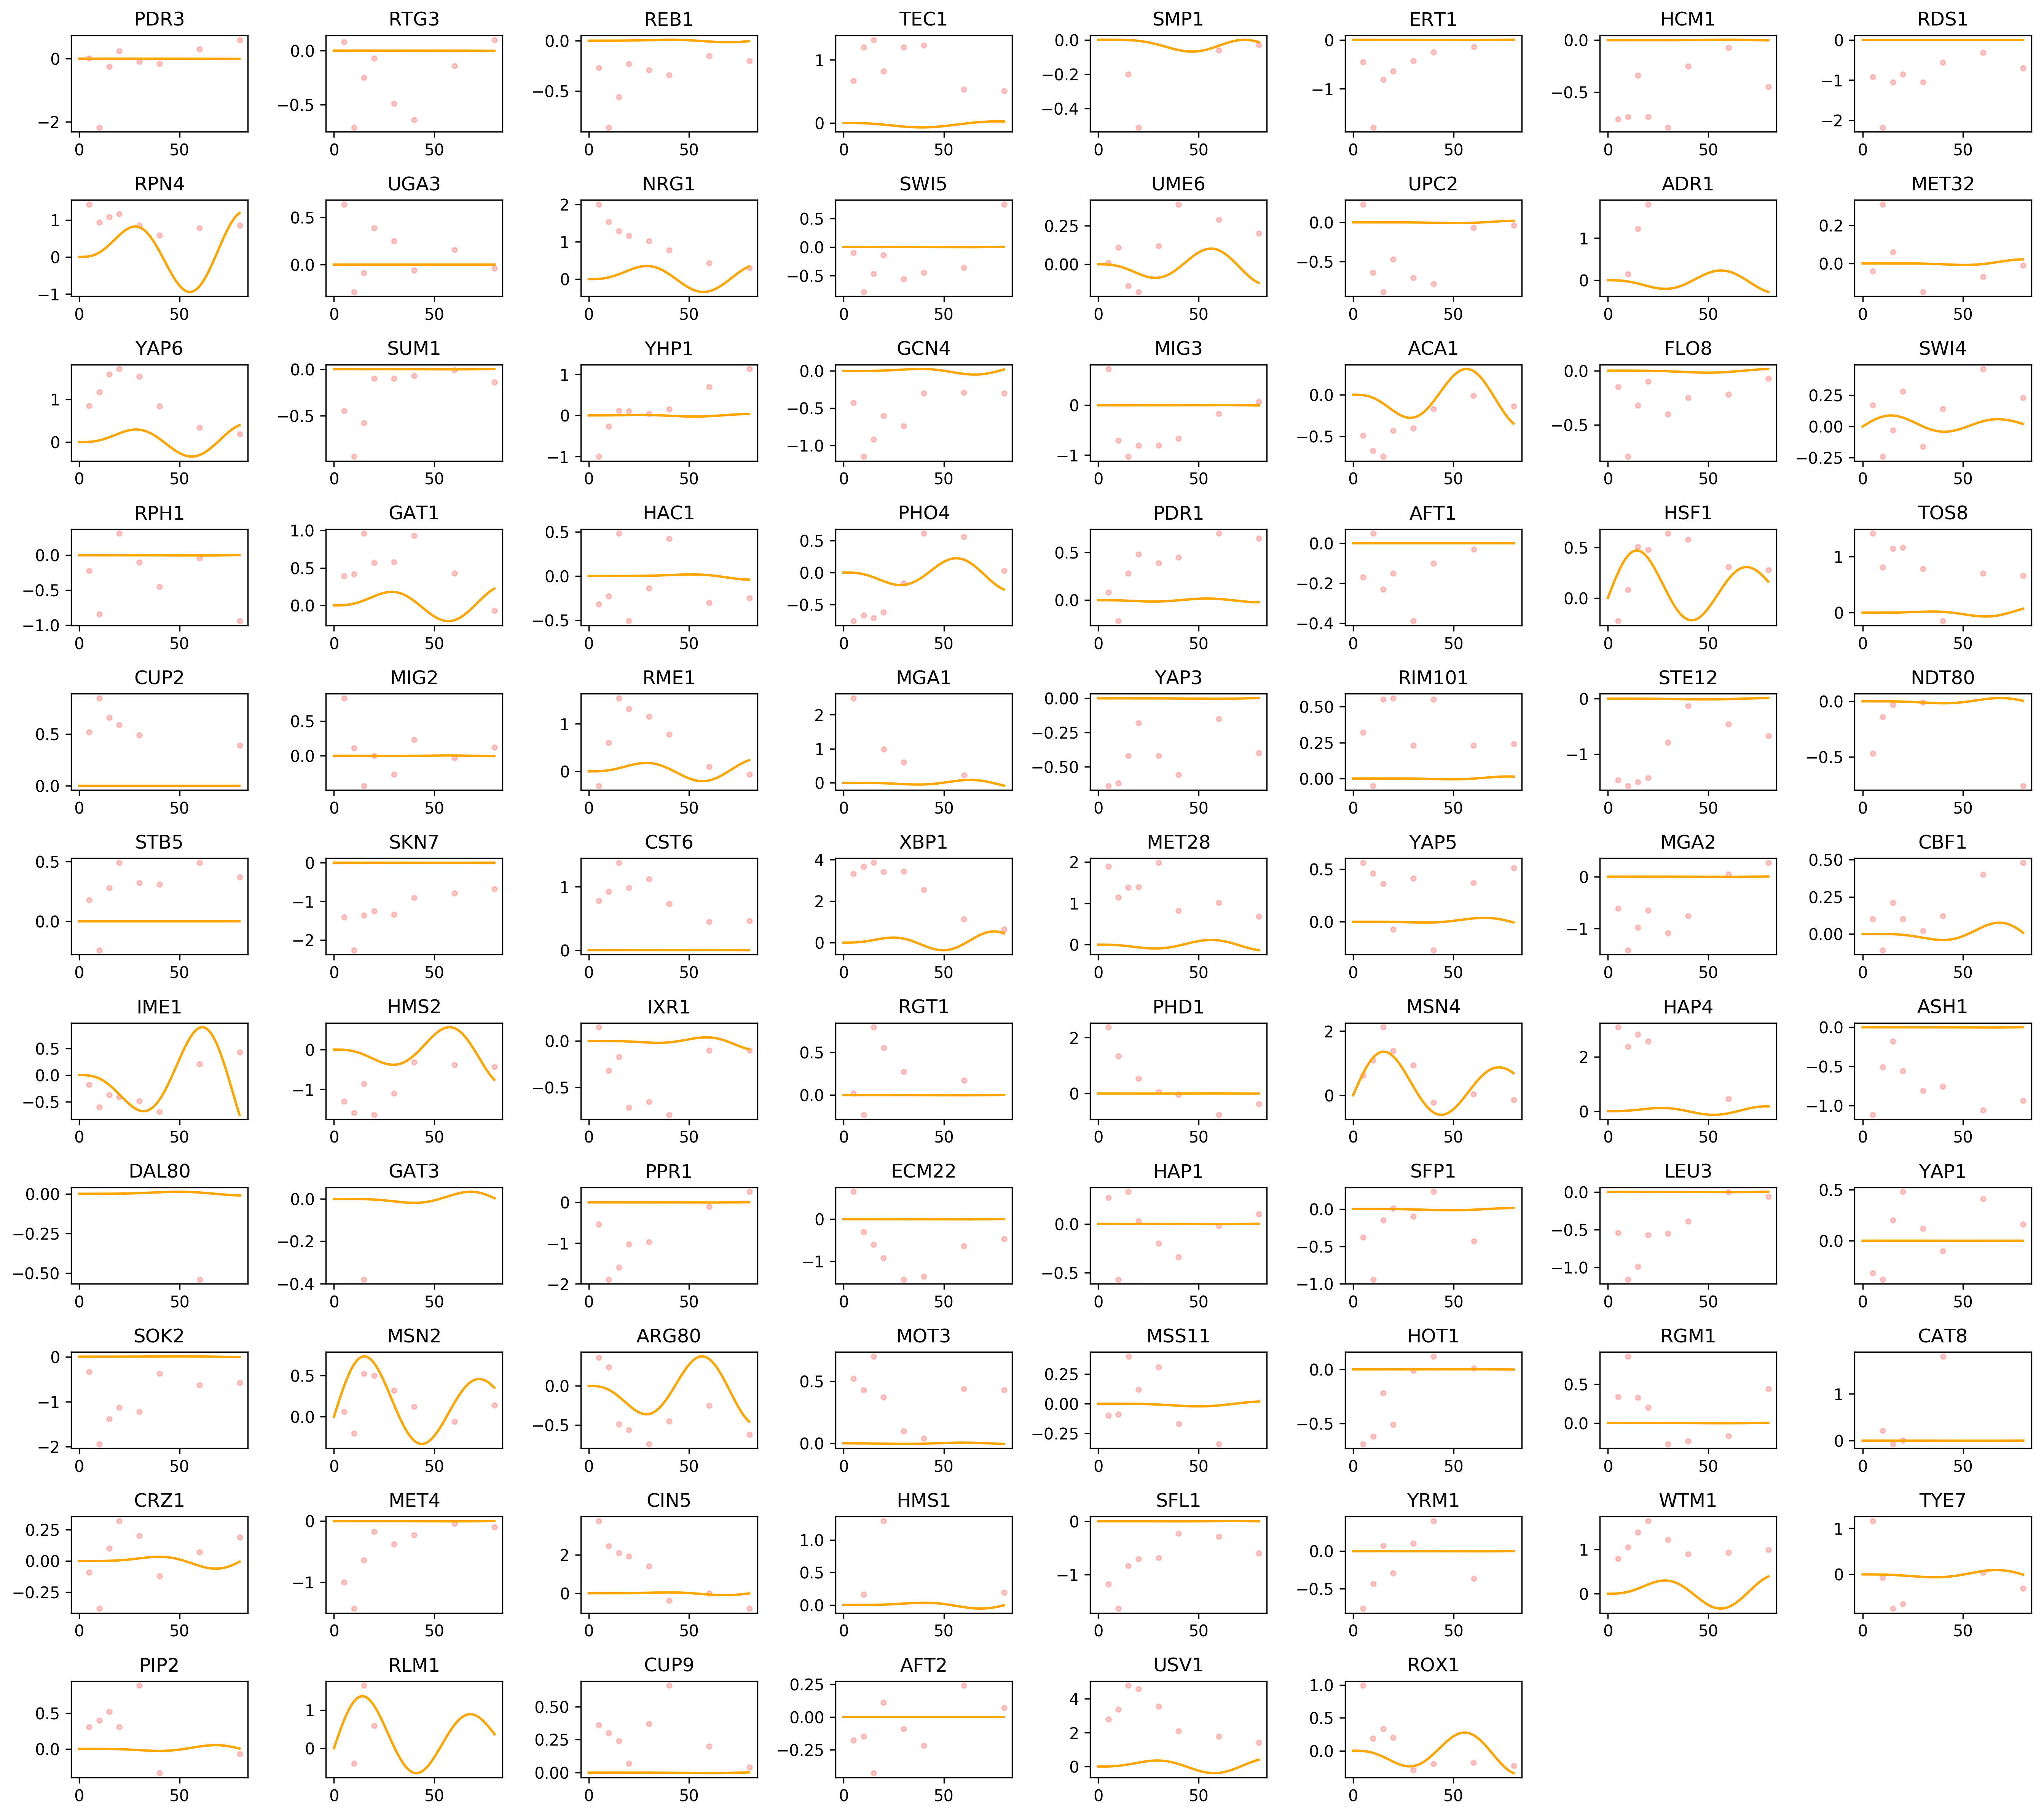

In [55]:
ts = np.arange(0, 80, 0.1)
y_pred = get_predictions_f3(fit_params_full.x, hss_indices, Aa, Ai, times=ts, n_hss=5)
y_data = gasch_data.iloc[:, 2:10].loc[subnet_nodelist]

plt.figure(figsize=(18, 16), dpi=300)
for i, node in enumerate(subnet_nodelist):
    plt.subplot(11, 8, i + 1)
    plt.plot(times[1:], y_data.iloc[i,:], '.', color="red", alpha=0.2)
    plt.plot(ts, y_pred[:, i], '-', color="orange")
    plt.title(node)
    #plt.plot(times, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '.-', color = 'red', alpha=0.3)
    #plt.xlim(0, 80)
    #plt.ylim(-2, 3)
plt.tight_layout()
plt.show()

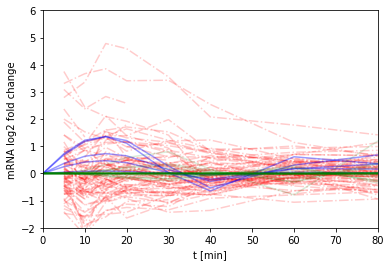

In [64]:
ts = np.array([0, 5, 10, 15, 20, 30, 40, 60, 80])
y_pred = get_predictions_f3(fit_params_full.x, hss_indices, Aa, Ai, times=ts, n_hss=5)


y_data = gasch_data.iloc[:, 2:10].loc[subnet_nodelist]
plt.plot(times[1:], np.transpose(y_data), '-.', color="red", alpha=0.2)
plt.plot(ts, y_pred[:, hss_indices], '-', color="blue", alpha=0.4)
plt.plot(ts, y_pred[:, [i for i in range(31) if i not in hss_indices ]], '-', color = 'green', alpha=0.15)
plt.xlim(0, 80)
plt.ylim(-2, 6)
plt.xlabel('t [min]')
plt.ylabel('mRNA log2 fold change')
plt.show()

## Including nonlinearity

In [58]:
# Model 4: mRNA and protein, separate inhibition and activation, limited activation.
def f3(y, t0, u, k_tf, kf, k_prot, k_max, k_width Aa, Ai):
    '''
    u: N-vector of initial activation strength.
    k_tf: N-vector of TF strengths.
    kf: N-vector of feedbacks for each gene.
    k_prot: Protein constant.
    Aa, Ai: activator and inhibitor adj. matrices
    '''
    N =  len(y)
    # Separate into mRNA and protein.
    m = y[:N // 2]
    p = y[N //2:]
    
    A = Aa - Ai
    #print(A.shape)
    #A = (k_tf * A.transpose()).transpose()
    
    dm = k_max * (A @ p / k_width) - kf * p + u
    dp = k_prot * (m - p)
    #return (A - kf * np.identity(len(A))) @ y + u
    return np.concatenate((dm, dp))

def error_prot_model_limited(params, y_data, N, hss_indices, Aa, Ai, n_hss=5):
    '''
    params: Parameter vector.
    y_data: Real data.
    N: Number of genes/nodes.
    hss_indices: gene indices of heat shock starters
    n_hss: Number of heat shock starters.
    
    returns: MSE of model predictions with specified parameters.
    '''
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    k_prot = params[-1]
    
    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=np.array([5, 10, 15, 20, 30, 40, 60, 80]),
               args=(u, k_tf, kf, k_prot, Aa, Ai))
    m = y[:,:N]
    
    # Return mean absolute error.
    return np.nanmean(np.abs(m - y_data))

def get_predictions_f3(params, hss_indices, Aa, Ai, times=np.array([0, 5, 10, 15, 20, 30, 40, 60, 80]),
                   n_hss=5):
    # Strength of activation for HSS (heat shock starters).
    u0 = params[:n_hss]
    #print('u0', len(u0))
    
    # Feedback strength for all nodes (transcription factors).
    kf = params[n_hss: n_hss + N]
    #print('kf', len(kf), kf)
    
    # Strength of activation/inhibition for all nodes.
    k_tf = params[n_hss + N: n_hss + 2*N]
    #print('k_tf', len(k_tf))
    k_prot = params[-1]
    #print(k_prot)

    # General activation, inhibition and feedback constants.
    #k_max, k_width, k_prot = params[-6:]
    #ka, ki, k_prot = params[-3:]
    
    # Set initial conditions and inputs to zero for everything
    # (HSS conditions are changed later).
    y0 = np.zeros(N * 2)
    u = np.zeros(N)
    #kf = np.repeat(kf, N)
    
    # Change inputs and feedback constant for HSS.
    for i, index in enumerate(hss_indices):
        u[index] = u0[i]
        #kf[index] = kf0[i]
    
    y = odeint(f3, y0=y0, t=times,
               args=(u, k_tf, kf, k_prot, Aa, Ai),)
    return y[:,:N]

SyntaxError: invalid syntax (<ipython-input-58-b78c6b3b3f6f>, line 2)

In [71]:
len(fit_params.x)

68

In [69]:
u0 = fit_params.x[:5]
kf = fit_params.x[5:38]
k_tf = fit_params[38:71]
k_prot

array([ 0.05233833,  0.07731447,  0.14332447,  0.15388322,  0.01      ,
        0.13285213,  0.34369886,  0.57825118,  0.17525861,  0.06107679,
        0.69969501,  0.70149102,  0.69998746,  0.74735076,  0.69999738,
        0.70050618,  0.69992812,  0.69738656,  0.69828342,  0.69440911,
        0.69968279,  0.69430208,  0.69908228,  0.70668454,  0.69676294,
        0.69953895,  0.7050423 ,  0.69740183,  0.70290872,  0.69866716,
        0.67154185,  0.70171097,  0.69294271,  0.70006347,  0.70000057,
        0.6706115 ,  0.71402701,  0.69147889,  0.69382653,  0.67303879,
        0.70342244,  0.69866668,  0.700072  ,  0.70045339,  0.70292138,
        0.7000124 ,  0.69911298,  0.69866668,  0.71199663,  0.6860874 ,
        0.69330619,  0.70115452,  0.69866743,  0.64848267,  0.70978796,
        0.69569056,  0.70031481,  0.72527884,  0.6085196 ,  0.70087157,
        0.69839725,  0.70326351,  0.69999904,  0.70045334,  0.69866668,
        0.70058007,  0.69801102,  0.69912176,  0.70019705,  0.70

In [77]:
import pickle

outfile = open('fit_params_subnetwork.p', 'wb')
# This saves the numpy array with the parameters into a file.
pickle.dump(fit_params, outfile)
outfile.close()

In [94]:
fit_params_full

      fun: 0.6029883379815969
 hess_inv: <178x178 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.18001506e-02,  -3.30767636e-03,  -4.65530392e-02,
         8.94074814e-03,  -1.36051170e-03,  -6.27942143e-05,
        -4.03010958e-06,   1.61759495e-05,   3.20699023e-04,
         1.61538560e-03,   5.26245714e-06,  -1.58761893e-05,
         1.33226763e-07,  -4.27402558e-04,   1.11022302e-07,
        -1.08686393e-03,   2.39808173e-06,   1.69420034e-05,
         2.33812969e-05,   1.38229428e-03,   1.02362563e-05,
         2.76593193e-03,   1.25011113e-05,  -4.29989377e-05,
         8.22342194e-05,   3.08642001e-06,   3.80184773e-04,
         2.44249065e-05,   2.54785082e-04,   1.29007915e-05,
         1.51851864e-03,  -2.70339306e-05,  -1.76703097e-04,
        -1.02395870e-04,   0.00000000e+00,   3.28849170e-03,
        -2.78155277e-04,   0.00000000e+00,   4.24105195e-06,
         1.44503298e-03,   2.23154828e-06,   1.29007915e-05,
         1.16573418e-06,   3.27182725e-05,  -

In [95]:
outfile2 = open('fit_params_full.p', 'wb')
# This saves the numpy array with the parameters into a file.
pickle.dump(fit_params_full, outfile2)
outfile.close()

In [87]:
def get_gene_successors(tf_list, full_mixed_network):
    succ_genes = []
    for tf in tf_list:
        # Get list of successors that are not TFs.
        succ_genes.extend([gene for gene in full_mixed_network.successors(tf)
                          if full_mixed_network.out_degree(gene) == 0])
    return list(set(succ_genes))

tf_and_successors = list(nodes1) + get_gene_successors(nodes1, mixed_network)

In [88]:
len(get_gene_successors(nodes1, mixed_network))

1331

In [85]:
tf_and_successors = list(nodes1) + list(get_gene_successors(nodes1, mixed_network))

In [90]:
sn1 = combine_networks(sn1_act, sn1_inh)
path_lengths_sn1 = np.array([shortest_path_to_hss(sn1, node, heat_shock_starters) for node in sn1.nodes()])

In [91]:
for node in sn_act.nodes():
    print(shortest_path_to_hss(sn, node, heat_shock_starters),
          node, sn_act.in_degree(node), sn_inh.in_degree(node), sn_act.in_degree(node) + sn_inh.in_degree(node))

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1])

In [93]:
in_degrees

[1,
 6,
 2,
 1,
 3,
 2,
 2,
 1,
 0,
 3,
 1,
 3,
 0,
 1,
 1,
 1,
 4,
 3,
 4,
 2,
 4,
 2,
 3,
 2,
 2,
 3,
 2,
 4,
 0,
 3,
 2]